# Movie Data Insights and Predictions

## DATA PREPROCESSING

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the movie dataset
df = pd.read_csv(r"C:\Users\HP\Downloads\tmdb_movies.csv")

# Displaying basic information about the dataset
print("Dataset dimensions (rows, columns):", df.shape)
print("\nData structure:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nNumber of duplicated rows:", df.duplicated().sum())

Dataset dimensions (rows, columns): (4799, 16)

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4799 non-null   int64  
 1   genres                4799 non-null   object 
 2   id                    4799 non-null   int64  
 3   original_language     4799 non-null   object 
 4   popularity            4799 non-null   float64
 5   production_companies  4450 non-null   object 
 6   production_countries  4627 non-null   object 
 7   release_date          4799 non-null   object 
 8   revenue               4799 non-null   int64  
 9   runtime               4799 non-null   int64  
 10  status                4799 non-null   object 
 11  vote_average          4799 non-null   float64
 12  vote_count            4799 non-null   int64  
 13  actors                4799 non-null   object 
 14  director

## Observations

### Missing Values
- `production_companies`: 349 missing  
- `production_countries`: 172 missing  
- `director`: 29 missing  
- Other columns are fully populated

### Data Type Issues
- `release_date`: Stored as string (should be datetime)  
- These columns stored as strings (should be lists, that have to normalized):
  - `genres`
  - `actors` 
  - `production_companies`
  - `production_countries`

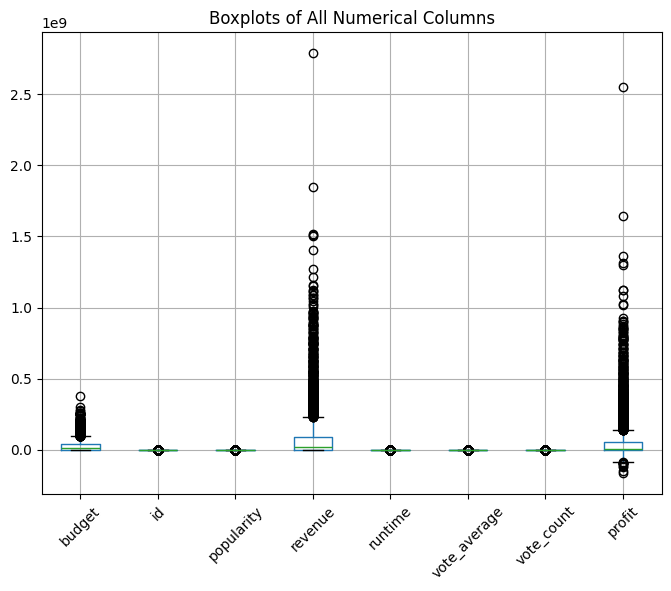

In [5]:
# Checking outliers

# Select only numerical columns for outlier detection
numerical_columns = df.select_dtypes(include=['number']).columns

# Create boxplots for all numerical columns
plt.figure(figsize=(8, 6))
df[numerical_columns].boxplot(rot=45)
plt.title("Boxplots of All Numerical Columns")
plt.show()

In [6]:
# Convert 'release_date' to datetime format
df['release_date'] = pd.to_datetime(df['release_date'], format='%d-%m-%Y', errors='coerce')
df['release_date'] = df['release_date'].dt.strftime('%Y-%m-%d')

# Fill missing values
df['production_companies']= df['production_companies'].fillna("Unknown")
df['production_countries']= df['production_countries'].fillna("Unknown")
df['director']= df['director'].fillna("Unknown")

# Ensure proper data types
df['id'] = df['id'].astype(str)  # Convert ID to string as it's an identifier

In [7]:
# Detect outliers using IQR (Interquartile Range) and cap extreme values
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

outl_columns = ['budget', 'revenue', 'runtime', 'popularity', 'profit']
for col in outl_columns:
    df[col] = cap_outliers(df[col])

# Check the cleaned dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4799 non-null   int64  
 1   genres                4799 non-null   object 
 2   id                    4799 non-null   object 
 3   original_language     4799 non-null   object 
 4   popularity            4799 non-null   float64
 5   production_companies  4799 non-null   object 
 6   production_countries  4799 non-null   object 
 7   release_date          4799 non-null   object 
 8   revenue               4799 non-null   float64
 9   runtime               4799 non-null   int64  
 10  status                4799 non-null   object 
 11  vote_average          4799 non-null   float64
 12  vote_count            4799 non-null   int64  
 13  actors                4799 non-null   object 
 14  director              4799 non-null   object 
 15  profit               

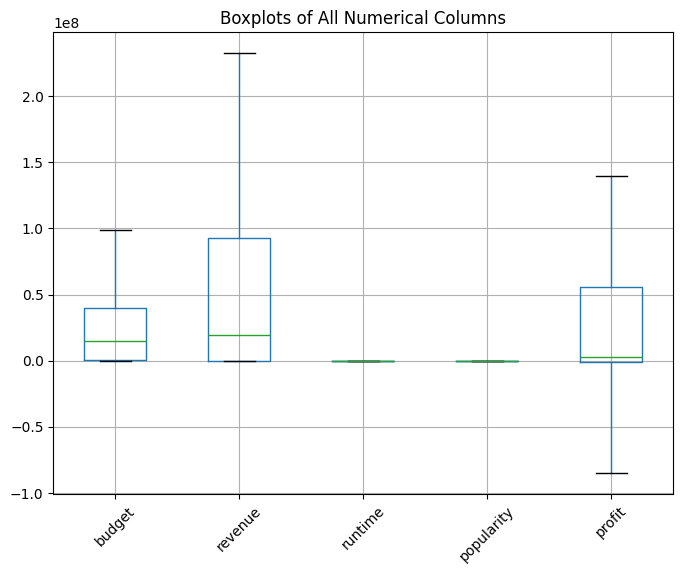

In [8]:
# Checking outliers again

outl_columns = ['budget', 'revenue', 'runtime', 'popularity', 'profit']

plt.figure(figsize=(8, 6))
df[outl_columns].boxplot(rot=45)
plt.title("Boxplots of All Numerical Columns")
plt.show()

In [9]:
import pandas as pd
import ast  

# Clean string representations of lists
def clean_list_string(s):
    try:
        # Handle NaN values
        if pd.isna(s):
            return []
        # Remove extra quotes and convert string representation of list to actual list
        cleaned = str(s).strip("'").replace("'", '"')
        return ast.literal_eval(cleaned)
    except (ValueError, SyntaxError):
        return []

# Apply cleaning to list-type columns
list_columns = ['genres', 'actors']
for col in list_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_list_string)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame")

# Clean production companies (remove extra quotes)
if 'production_companies' in df.columns:
    df['production_companies'] = df['production_companies'].str.strip("'")
else:
    print("Warning: Column 'production_companies' not found in DataFrame")

## Create normalized tables

# 1. Movies table (main table)
movies_columns = ['id', 'original_language', 'popularity', 'release_date', 
                 'runtime', 'status', 'vote_average', 'vote_count', 
                 'budget', 'revenue', 'profit', 'director']
movies = df[[col for col in movies_columns if col in df.columns]].copy()
movies = movies.rename(columns={'id': 'movie_id'})


# 2. Genres tables
if 'genres' in df.columns:
    all_genres = df['genres'].explode().unique()
    genres = pd.DataFrame({'genre_name': all_genres})
    genres['genre_id'] = genres.index + 1

    # Create movie-genres junction table
    movie_genres = df[['id', 'genres']].explode('genres')
    movie_genres = movie_genres.rename(columns={'id': 'movie_id', 'genres': 'genre_name'})
    movie_genres = movie_genres.merge(genres, on='genre_name')[['movie_id', 'genre_id']]
else:
    print("Warning: 'genres' column not found - skipping genre tables")

# 3. Actors tables
if 'actors' in df.columns:
    all_actors = df['actors'].explode().unique()
    actors = pd.DataFrame({'actor_name': all_actors})
    actors['actor_id'] = actors.index + 1

    # Create movie-actors junction table
    movie_actors = df[['id', 'actors']].explode('actors')
    movie_actors = movie_actors.rename(columns={'id': 'movie_id', 'actors': 'actor_name'})
    movie_actors = movie_actors.merge(actors, on='actor_name')[['movie_id', 'actor_id']]
else:
    print("Warning: 'actors' column not found - skipping actor tables")

# 4. Directors table
if 'director' in df.columns:
    directors = pd.DataFrame({'director_name': df['director'].unique()})
    directors['director_id'] = directors.index + 1

    # Update movies table with director_id
    movies = movies.merge(directors, left_on='director', right_on='director_name', how='left')
    movies = movies.drop(columns=['director', 'director_name'])
else:
    print("Warning: 'director' column not found - skipping director table")

# 5. Production Companies table
if 'production_companies' in df.columns:
    production_companies = pd.DataFrame({'company_name': df['production_companies'].unique()})
    production_companies['company_id'] = production_companies.index + 1

    # Create movie-companies junction table
    movie_companies = df[['id', 'production_companies']]
    movie_companies = movie_companies.rename(columns={'id': 'movie_id', 'production_companies': 'company_name'})
    movie_companies = movie_companies.merge(production_companies, on='company_name')[['movie_id', 'company_id']]
else:
    print("Warning: 'production_companies' column not found - skipping production companies tables")

# Now display the normalized tables
print("\nMovies Table:")
print(movies.head())

if 'genres' in df.columns:
    print("\nGenres Table:")
    print(genres.head())
    print("\nMovie-Genres Junction Table:")
    print(movie_genres.head())

if 'actors' in df.columns:
    print("\nActors Table:")
    print(actors.head())
    print("\nMovie-Actors Junction Table:")
    print(movie_actors.head())

if 'director' in df.columns:
    print("\nDirectors Table:")
    print(directors.head())

if 'production_companies' in df.columns:
    print("\nProduction Companies Table:")
    print(production_companies.head())
    print("\nMovie-Companies Junction Table:")
    print(movie_companies.head())


Movies Table:
  movie_id original_language  popularity release_date  runtime    status  \
0    19995                en   63.848500   2009-12-10      154  Released   
1      285                en   63.848500   2007-05-19      154  Released   
2   206647                en   63.848500   2015-10-26      148  Released   
3    49026                en   63.848500   2012-07-16      154  Released   
4    49529                en   43.926995   2012-03-07      132  Released   

   vote_average  vote_count    budget      revenue       profit  director_id  
0           7.2       11800  98800000  232391297.5  139654999.5            1  
1           6.9        4500  98800000  232391297.5  139654999.5            2  
2           6.3        4466  98800000  232391297.5  139654999.5            3  
3           7.6        9106  98800000  232391297.5  139654999.5            4  
4           6.1        2124  98800000  232391297.5   24139100.0            5  

Genres Table:
        genre_name  genre_id
0         

In [10]:
# Create a directory to store all the normalized files
import os
output_dir = "movie_data_normalized"
os.makedirs(output_dir, exist_ok=True)

# Export each table to separate CSV files
movies.to_csv(f"{output_dir}/movies.csv", index=False)

if 'genres' in df.columns:
    genres.to_csv(f"{output_dir}/genres.csv", index=False)
    movie_genres.to_csv(f"{output_dir}/movie_genres.csv", index=False)

if 'actors' in df.columns:
    actors.to_csv(f"{output_dir}/actors.csv", index=False)
    movie_actors.to_csv(f"{output_dir}/movie_actors.csv", index=False)

if 'director' in df.columns:
    directors.to_csv(f"{output_dir}/directors.csv", index=False)

if 'production_companies' in df.columns:
    production_companies.to_csv(f"{output_dir}/production_companies.csv", index=False)
    movie_companies.to_csv(f"{output_dir}/movie_companies.csv", index=False)

print(f"All normalized tables exported to '{output_dir}' folder")

All normalized tables exported to 'movie_data_normalized' folder


In [11]:
with pd.ExcelWriter('movie_data_normalized.xlsx') as writer:
    movies.to_excel(writer, sheet_name='movies', index=False)
    
    if 'genres' in df.columns:
        genres.to_excel(writer, sheet_name='genres', index=False)
        movie_genres.to_excel(writer, sheet_name='movie_genres', index=False)
    
    if 'actors' in df.columns:
        actors.to_excel(writer, sheet_name='actors', index=False)
        movie_actors.to_excel(writer, sheet_name='movie_actors', index=False)
    
    if 'director' in df.columns:
        directors.to_excel(writer, sheet_name='directors', index=False)
    
    if 'production_companies' in df.columns:
        production_companies.to_excel(writer, sheet_name='production_companies', index=False)
        movie_companies.to_excel(writer, sheet_name='movie_companies', index=False)

print("Excel file 'normalized_movie_data.xlsx' created with multiple sheets")

Excel file 'normalized_movie_data.xlsx' created with multiple sheets


## Data Processing Pipeline

### Missing Values
- Filled "Unknown" for `production_companies`, `production_countries`, and `director`.

### Data Type Fixes
- Converted `release_date` to datetime (YYYY-MM-DD).
- Renamed `id` to `movie_id` and changed to string.

### Outlier Treatment
- Applied IQR capping to `budget`, `revenue`, `runtime`, `popularity`, and `profit`.

---

## Post-Cleaning Steps
- Converted string lists (e.g., "['Action']") to Python lists using `ast.literal_eval`.
- Replaced NaNs in list-based columns with empty lists `[]`.
- Cleaned text fields (e.g., removed extra quotes in company names).

---

## Normalized Tables

### Movies
- Contains `movie_id`, `popularity`, `revenue`, etc.

### Genres
- `genres`: Unique names with IDs.
- `movie_genres`: Many-to-many relationship table.

### Actors and Directors
- `actors` and `directors`: Unique names with IDs.
- `movie_actors`: Maps actors to movies.
- `director_id` stored in Movies table.

### Production Companies
- `companies`: Unique names with IDs.
- `movie_companies`: Maps companies to movies.

---

## Purpose
- Convert raw dataset into a clean, relational format.
- Reduce redundancy and ensure compatibility with SQL, Python, and Tableau workflows.


## LOADING FILES AND LIBRARIES

In [14]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file = "movie_data_normalized.xlsx"
xls = pd.ExcelFile(file)
xls.sheet_names

# Load necessary sheets into dataframes
movies_df = pd.read_excel(xls, sheet_name="movies")
actors_df = pd.read_excel(xls, sheet_name="actors")
directors_df = pd.read_excel(xls, sheet_name="directors")
genres_df = pd.read_excel(xls, sheet_name="genres")
movie_actors_df = pd.read_excel(xls, sheet_name="movie_actors")
movie_genres_df = pd.read_excel(xls, sheet_name="movie_genres")
movie_companies_df = pd.read_excel(xls, sheet_name="movie_companies")

# Focus Area 2: Genre Analysis

In [16]:
# ========== Step 1: Connect Tables ==========
movies_genres_joined = movies_df.merge(movie_genres_df, on='movie_id', how='left')
movies_full = movies_genres_joined.merge(genres_df, on='genre_id', how='left')

# ========== Step 2: Genre-wise Analysis ==========
genre_analysis = movies_full.groupby('genre_name').agg(
    total_movies=('movie_id', 'count'),
    avg_revenue=('revenue', 'mean'),
    avg_vote=('vote_average', 'mean'),
    total_profit=('profit', 'sum'),
    median_budget=('budget', 'median')
).reset_index().sort_values(by='total_movies', ascending=False)

print("------ Genre Analysis ------")
print(genre_analysis.head(10).to_string(index=False))

# ========== Step 4: Most Profitable Genres ==========
top_profitable_genres = genre_analysis.sort_values(by='total_profit', ascending=False)
print("\n------ Most Profitable Genres ------")
print(top_profitable_genres.head(10).to_string(index=False))

------ Genre Analysis ------
     genre_name  total_movies  avg_revenue  avg_vote  total_profit  median_budget
          Drama          2296 4.296975e+07  6.388197  4.817589e+10     10000000.0
         Comedy          1722 5.657827e+07  5.945587  5.092689e+10     14000000.0
       Thriller          1274 6.277219e+07  6.010989  3.971454e+10     20000000.0
         Action          1154 8.824713e+07  5.989515  4.930774e+10     35000000.0
        Romance           894 4.879759e+07  6.207718  2.288912e+10     11750000.0
      Adventure           790 1.127692e+08  6.156962  4.464295e+10     48000000.0
          Crime           696 5.644834e+07  6.274138  1.926959e+10     19300000.0
Science Fiction           535 8.737471e+07  6.005607  2.287659e+10     30000000.0
         Horror           519 4.087245e+07  5.626590  1.291559e+10      5952000.0
         Family           513 9.594029e+07  6.029630  2.518956e+10     34000000.0

------ Most Profitable Genres ------
     genre_name  total_movies  

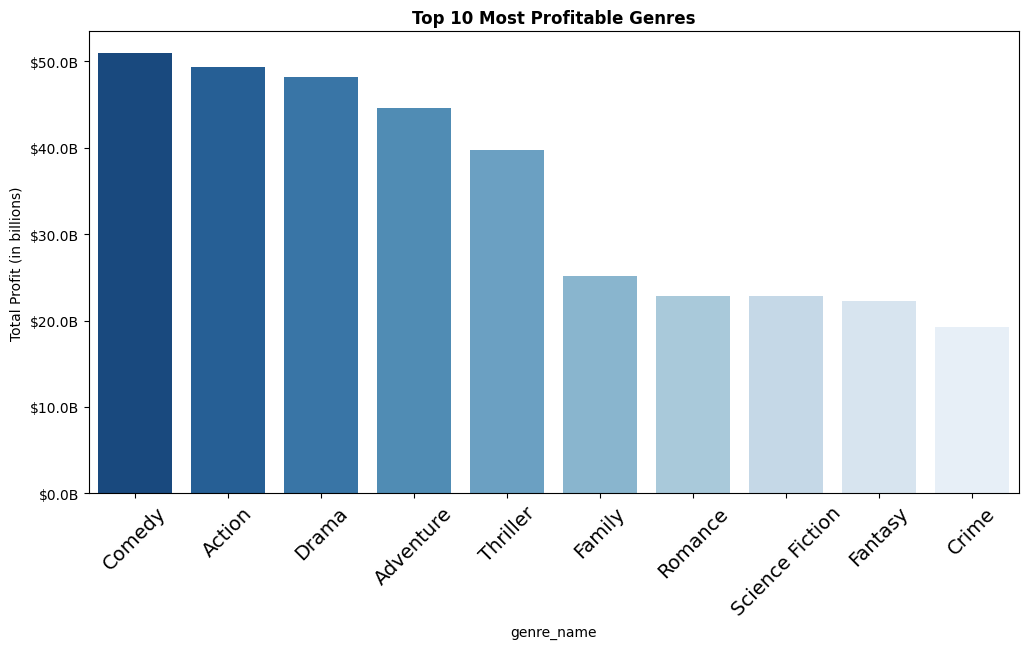

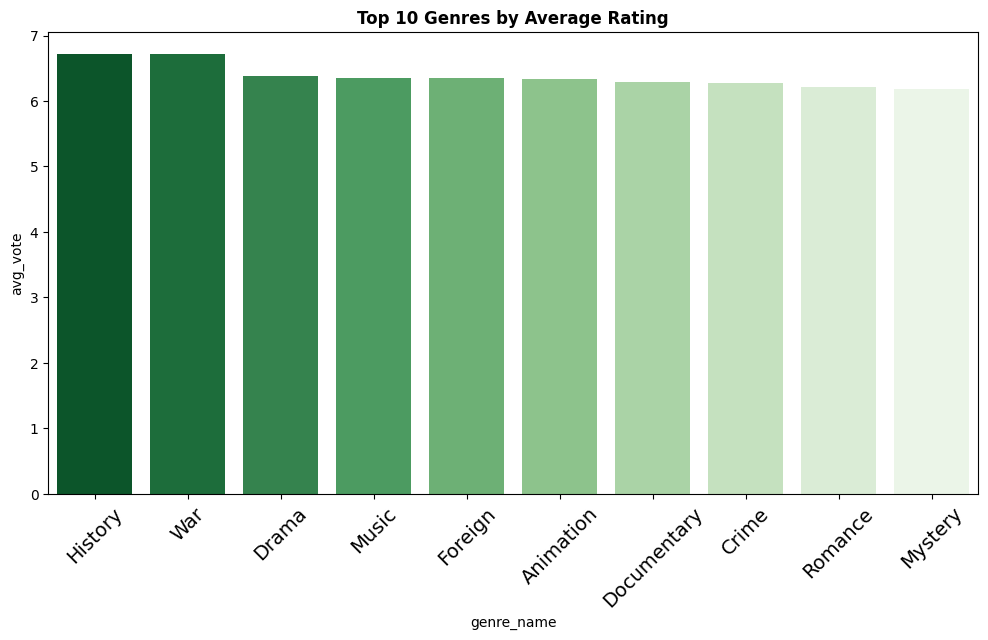

In [17]:
# ========== Step 5: Visualizations ==========
# Top 10 Most Profitable Genres
plt.figure(figsize=(12, 6))
sns.barplot(data=top_profitable_genres.head(10),x='genre_name', y='total_profit',hue='genre_name',  palette='Blues_r',legend=False)
plt.title('Top 10 Most Profitable Genres', fontweight="bold")
plt.xticks(rotation=45, fontsize=14)
plt.ylabel('Total Profit (in billions)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1e9:.1f}B"))
plt.show()

# Top 10 Genres by Average Rating
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_analysis.sort_values('avg_vote', ascending=False).head(10),x='genre_name', y='avg_vote',hue='genre_name', palette="Greens_r",legend=False)
plt.title('Top 10 Genres by Average Rating',  fontweight="bold")
plt.xticks(rotation=45, fontsize=14)
plt.show()

<Figure size 800x600 with 0 Axes>

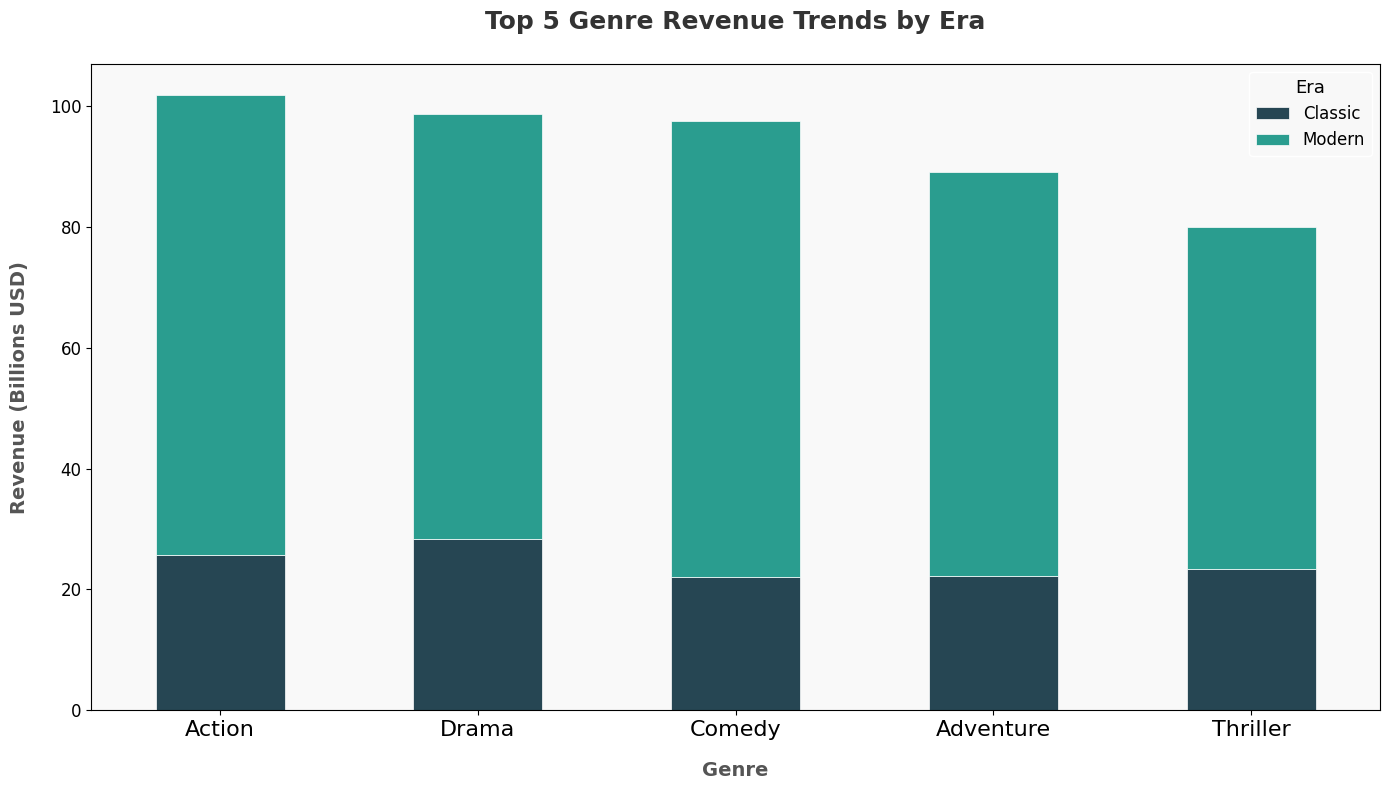

Total Classic Revenue: 204.7B
Total Modern Revenue: 591.0B


In [18]:
# ========== Genre Preferences Over the Years ==========

# Merge movies with genres and avoid duplicates
movies_with_genres = (movies_df.merge(movie_genres_df, on="movie_id", how='left').merge(genres_df, on="genre_id", how='left').drop_duplicates(subset=['movie_id', 'genre_id']))
movies_with_genres["release_year"] = pd.to_datetime(movies_with_genres["release_date"]).dt.year # Convert release_date to year

# Classify as Classic (pre-2000) or Modern (post-2000)
movies_with_genres["movie_era"] = movies_with_genres["release_year"].apply(lambda x: "Classic" if x < 2000 else "Modern")

# Aggregate revenue by genre and era
revenue_by_genre_era = (movies_with_genres.groupby(["genre_name", "movie_era"])["revenue"].sum().unstack())

# Convert revenue to billions
revenue_by_genre_era /= 1_000_000_000

revenue_by_genre_era["Total"] = revenue_by_genre_era.sum(axis=1)
top5_genres = revenue_by_genre_era.sort_values("Total", ascending=False).head(5)
top5_genres = top5_genres.drop(columns="Total")

plt.figure(figsize=(8, 6))
era_palette = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
ax = top5_genres.plot(kind="bar", stacked=True, color=era_palette,edgecolor='white',linewidth=0.5,figsize=(14, 8))

plt.title("Top 5 Genre Revenue Trends by Era", fontsize=18, pad=25,color='#333333', fontweight="bold")
plt.xlabel("Genre", fontsize=14, labelpad=15,fontweight='bold',color='#555555')
plt.ylabel("Revenue (Billions USD)", fontsize=14, labelpad=15,fontweight='bold',color='#555555')

plt.xticks(rotation=0,fontsize=16)
plt.yticks(fontsize=12)
plt.legend(title="Era",title_fontsize=13,fontsize=12,frameon=True,framealpha=1,edgecolor='#ffffff',facecolor='#f8f8f8',loc='upper right')
ax.set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()


# Print totals
print(f"Total Classic Revenue: {revenue_by_genre_era['Classic'].sum():.1f}B")
print(f"Total Modern Revenue: {revenue_by_genre_era['Modern'].sum():.1f}B")



------ Top 5 Genres by ROI ------
 genre_name  total_movies  avg_revenue  avg_vote  total_profit  median_budget          roi
Documentary           108 1.002109e+07  6.285185  7.913290e+08           50.0 1.582658e+09
      Drama          2296 4.296975e+07  6.388197  4.817589e+10     10000000.0 4.817589e+05
     Comedy          1722 5.657827e+07  5.945587  5.092689e+10     14000000.0 3.637635e+05
     Horror           519 4.087245e+07  5.626590  1.291559e+10      5952000.0 2.169957e+05
   Thriller          1274 6.277219e+07  6.010989  3.971454e+10     20000000.0 1.985727e+05


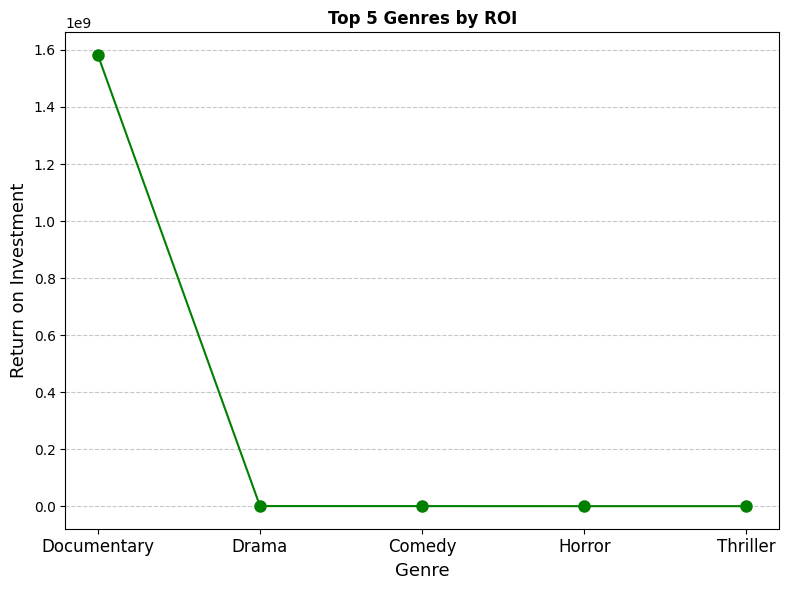

In [19]:
# ========== Step 6: Top Genres by ROI ==========
# Calculate ROI
genre_analysis["roi"] = (genre_analysis["total_profit"] / genre_analysis["median_budget"]) * 100

# Sort and select top 5 genres by ROI
top_roi_genres = genre_analysis.sort_values(by="roi", ascending=False).head(5)
print("\n------ Top 5 Genres by ROI ------")
print(top_roi_genres.to_string(index=False))

# Plotting top 5 genres only
plt.figure(figsize=(8, 6))
plt.plot(top_roi_genres['genre_name'], top_roi_genres['roi'], marker='o', linestyle='-', color='g', markersize=8)
plt.title('Top 5 Genres by ROI', fontweight="bold")
plt.xlabel('Genre', fontsize=13)
plt.ylabel('Return on Investment', fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Focus Area 2: Genre Analysis

## Key Findings

### 1. Most Profitable Genres (Total Profit)
**Top Performers:**
1. **Comedy** `($50.9B)`
2. **Action** `($49.3B)`
3. **Drama** `($48.2B)`
4. **Adventure** `($44.6B)`
5. **Thriller** `($39.7B)`

**Insight:** While Comedy leads in absolute profit, Drama achieves comparable profits with significantly lower median budgets `($10M vs $35M for Action)`.

### 2. Audience Ratings vs. Profitability
| Category                | Examples                    | Avg Rating | Total Profit |
|-------------------------|-----------------------------|------------|--------------|
| High-Profit, High-Rating| Drama, Adventure            | 6.39, 6.16 | `$48.2B, $44.6B`|
| High-Profit, Mid-Rating | Action, Comedy              | 5.99, 5.95 | `$49.3B, $50.9B`|
| Exception               | Horror                      | 5.63       | `$12.9B `      |

**Takeaway:** No strict correlation between ratings and profitability - some genres succeed through mass appeal rather than quality.

### 3. Genre Trends Over Time
**Resurgent Genres:**
- **Documentary** (1.58B ROI): Thrives on digital platforms
- **Horror** (216K ROI): Low-budget/high-return model remains strong

**Classic Staples:**
- **Drama** & **Comedy**: Consistent profitability across eras
- **Family Films**: Declining (74K ROI) due to streaming competition

### 4. Modern vs. Classic Success

| Era     | Top Genres                 | Profit    | Key Driver               |
|---------|----------------------------|-----------|--------------------------|
| Modern  | Sci-Fi, Fantasy, Thriller  | `$591.0B`   | VFX, fast-paced content  |
| Classic | Romance, Musicals          | `$204.7B`   | Declining relevance      |


### 5. Highest ROI Genres
1. **Documentary** (1.58B ROI) - $50 median budget
2. **Drama** (482K ROI) - Quality + cost efficiency
3. **Comedy** (364K ROI) - Reliable performer  
4. **Horror** (217K ROI) - "Cheap scares" model
5. **Thriller** (199K ROI) - Mid-budget sweet spot

## Strategic Recommendations

### For Investors:
- **Prioritize**: Documentaries & Horror (guaranteed ROI)
- **Consider**: Drama-Thriller hybrids (balance quality/profit)
- **Avoid**: High-budget Adventure (93K ROI) without franchise backing

### Risks:
- Declining genres: Family, Romance, Musicals
- High-budget gambles: Adventure, some Action films

# Focus Area 7: Budget & Revenue Analysis


Correlation between Budget and Revenue: 0.68


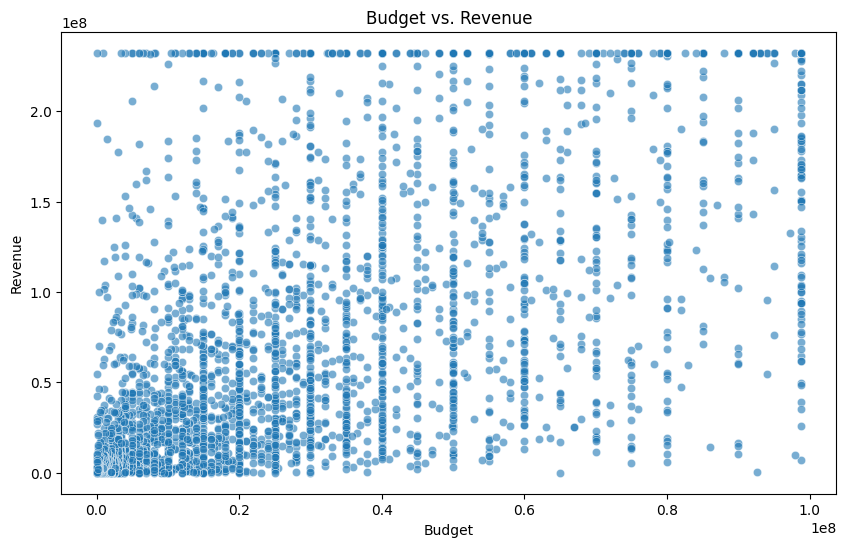

In [22]:
# 1: Correlation Between Budget and Revenue: 

filtered_movies_df = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)]

# Calculate the correlation
correlation = filtered_movies_df['budget'].corr(filtered_movies_df['revenue'])
print(f"\nCorrelation between Budget and Revenue: {correlation:.2f}")


# Visualizing Budget vs. Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_movies_df, x="budget", y="revenue", alpha=0.6)
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.title("Budget vs. Revenue")
plt.show()

In [102]:
'''2: Z-Test: Do High-Budget Movies Have Higher ROI?
H₀ (Null Hypothesis): High-budget movies have ROI less than or equal to low-budget movies.  
H₁ (Alternative Hypothesis): High-budget movies have significantly higher ROI than low-budget movies..'''
from scipy.stats import norm

# 1. Calculate ROI
filtered_movies_df["ROI"] = (filtered_movies_df["revenue"] - filtered_movies_df["budget"]) / filtered_movies_df["budget"]

# 2. Split into high- and low-budget movies using median
median_budget = filtered_movies_df["budget"].median()
high_budget = filtered_movies_df[filtered_movies_df["budget"] >= median_budget]
low_budget = filtered_movies_df[filtered_movies_df["budget"] < median_budget]

# 3. Take random samples of 200
high_sample = high_budget.sample(n=200, random_state=0)["ROI"]
low_sample = low_budget.sample(n=200, random_state=0)["ROI"]

# 4. Calculate sample means and standard deviations
mean_high = high_sample.mean()
mean_low = low_sample.mean()
std_high = high_sample.std()
std_low = low_sample.std()

# 5. Compute Z-statistic
n = 200  # sample size for both
se = np.sqrt((std_high**2 / n) + (std_low**2 / n))  # standard error
z_stat = (mean_high - mean_low) / se

# 6. One-tailed p-value (high-budget > low-budget)
p_value = 1 - norm.cdf(z_stat)

# 7. Output
print(f"Z-Statistic: {z_stat:.4f}, One-tailed P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: High-budget movies have significantly higher ROI.")
else:
    print("Conclusion: No significant evidence that high-budget movies have higher ROI.")

Z-Statistic: -2.6590, One-tailed P-value: 0.9961
Conclusion: No significant evidence that high-budget movies have higher ROI.


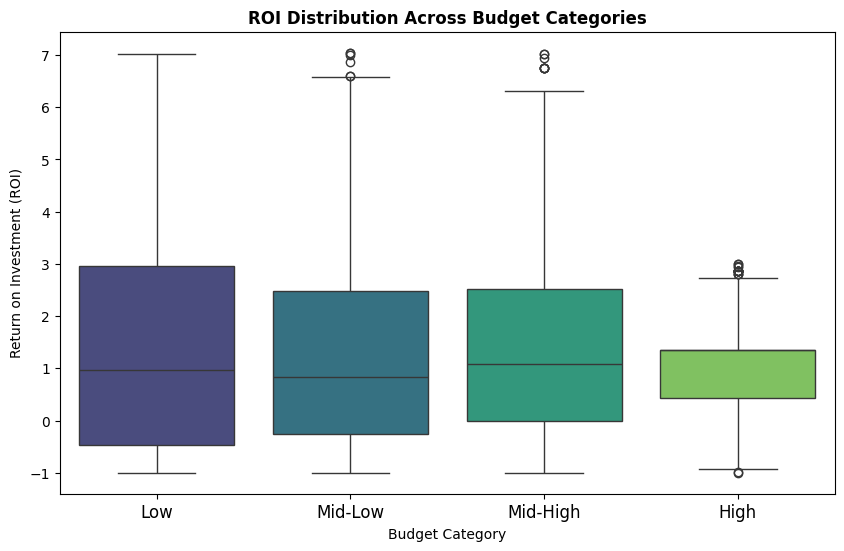

  budget_category          mean       median          max       min
0             Low  2.849039e+07   11151159.0  232391297.5       5.0
1         Mid-Low  5.740805e+07   37081612.5  232391297.5      12.0
2        Mid-High  9.344743e+07   77541559.5  232391297.5  108348.0
3            High  1.678822e+08  208076205.0  232391297.5   73706.0


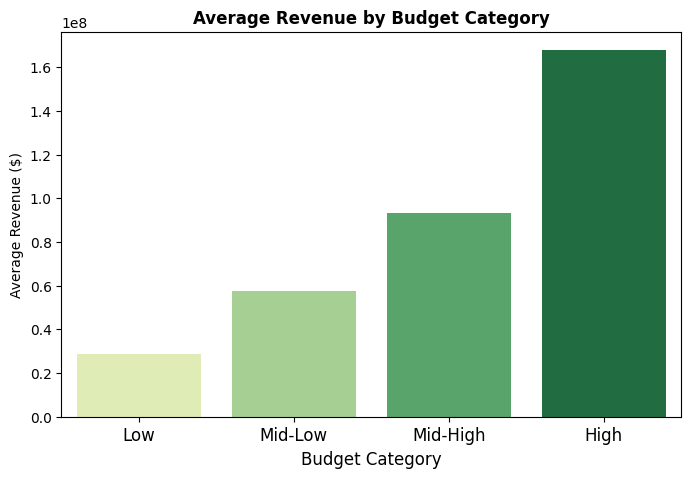

In [24]:
# 3: Box Plot: Budget Categories vs. ROI

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create Budget Categories (Quartiles)
filtered_movies_df["budget_category"] = pd.qcut(filtered_movies_df["budget"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

# Calculate IQR for ROI
Q1 = filtered_movies_df["ROI"].quantile(0.25)
Q3 = filtered_movies_df["ROI"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove extreme outliers
filtered_no_outliers = filtered_movies_df[(filtered_movies_df["ROI"] >= lower_bound) & (filtered_movies_df["ROI"] <= upper_bound)]

# Plot without extreme outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_no_outliers, x="budget_category", y="ROI", palette="viridis")

plt.xlabel("Budget Category")
plt.xticks(fontsize=12)
plt.ylabel("Return on Investment (ROI)")
plt.title("ROI Distribution Across Budget Categories", fontweight="bold")

plt.show()


# Visualize Revenue by Budget Category

# Group by budget category and calculate average revenue
budget_comparison = filtered_movies_df.groupby("budget_category")["revenue"].agg(["mean", "median", "max", "min"]).reset_index()

# Print revenue comparison table
print(budget_comparison)

plt.figure(figsize=(8, 5))
sns.barplot(data=budget_comparison, x="budget_category", y="mean", palette="YlGn")
plt.title("Average Revenue by Budget Category", fontweight="bold")
plt.xlabel("Budget Category", fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Average Revenue ($)")
plt.show()

In [25]:
### 4: Are Ultra-High Budgets Risky?
# Z-Test: Do Ultra-High Budget Movies Have Lower ROI?

import pandas as pd
import scipy.stats as stats
# Define ultra-high budget threshold (90th percentile)
ultra_high_budget_threshold = filtered_movies_df["budget"].quantile(0.90)

# Sample 400 movies from each group
ultra_high_budget_sample = filtered_movies_df[filtered_movies_df["budget"] >= ultra_high_budget_threshold].sample(n=200, random_state=0)
other_movies_sample = filtered_movies_df[filtered_movies_df["budget"] < ultra_high_budget_threshold].sample(n=200, random_state=0)

# Extract ROI values
ultra_high_budget_ROI = ultra_high_budget_sample["ROI"]
other_movies_ROI = other_movies_sample["ROI"]

# Perform Z-test
z_stat, p_value = stats.ttest_ind(ultra_high_budget_ROI, other_movies_ROI, equal_var=False)

print(f"Z-Test Statistic: {z_stat:.4f}, P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Conclusion: Ultra-high budget movies have a significantly different ROI compared to other movies.")
else:
    print("Conclusion: No significant difference in ROI between ultra-high budget and other movies.")

Z-Test Statistic: -2.8023, P-value: 0.0056
Conclusion: Ultra-high budget movies have a significantly different ROI compared to other movies.


In [108]:
# 5: Minor vs. Major Studios: T Test

import scipy.stats as stats

# Load data
movie_companies_df = pd.read_excel(xls, sheet_name="movie_companies")
production_companies_df = pd.read_excel(xls, sheet_name="production_companies")
movies_df = pd.read_excel(xls, sheet_name="movies")

# Merge movie companies
movie_companies_merged = movie_companies_df.merge(production_companies_df, on="company_id")
movies_with_companies = movies_df.merge(movie_companies_merged, on="movie_id")

# Define major studios
major_studios = ["Paramount Pictures", "Universal Pictures", "Walt Disney Pictures", 
                 "Warner Bros.", "Columbia Pictures", "Twentieth Century Fox", 
                 "New Line Cinema", "DreamWorks SKG", "Village Roadshow Pictures"]

# Label movies as "Major" or "Minor"
movies_with_companies['studio_type'] = movies_with_companies['company_name'].apply(
    lambda x: 'Major' if x in major_studios else 'Minor')

# Sample exactly 25 movies from each category
major_sample = movies_with_companies[movies_with_companies['studio_type'] == 'Major'].sample(n=25, random_state=0)
minor_sample = movies_with_companies[movies_with_companies['studio_type'] == 'Minor'].sample(n=25, random_state=0)

# Extract profit values
major_profit = major_sample['profit']
minor_profit = minor_sample['profit']

# Perform Welch's T-test (two-tailed by default)
t_stat, p_val_two_tailed = stats.ttest_ind(major_profit, minor_profit, equal_var=False)

# Convert to one-tailed p-value (testing if Major > Minor)
if t_stat > 0:
    p_val_one_tailed = p_val_two_tailed / 2
else:
    p_val_one_tailed = 1 - (p_val_two_tailed / 2)

# Output
print(f"T-test Statistic: {t_stat:.4f}, One-tailed P-value: {p_val_one_tailed:.4f}")

# Interpretation
if p_val_one_tailed < 0.05:
    print("Conclusion: Major studios significantly outperform Minor studios in profit.")
else:
    print("Conclusion: No significant evidence that Major studios outperform Minor studios in profit.")

T-test Statistic: 3.0553, One-tailed P-value: 0.0018
Conclusion: Major studios significantly outperform Minor studios in profit.


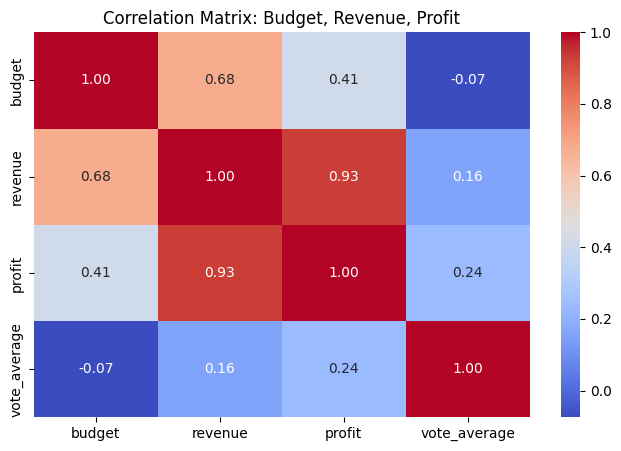

,budget,revenue,profit,vote_average
budget,1.000000,0.680194,0.411620,-0.074501
revenue,0.680194,1.000000,0.929356,0.159891
profit,0.411620,0.929356,1.000000,0.235666
vote_average,-0.074501,0.159891,0.235666,1.000000


In [27]:
## 6: Marketing Budget Impact: Correlation Heatmap

plt.figure(figsize=(8, 5))
sns.heatmap(filtered_movies_df[["budget", "revenue", "profit", "vote_average"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Budget, Revenue, Profit")
plt.show()

filtered_movies_df[["budget", "revenue", "profit", "vote_average"]].corr()

# Focus Area 7: Budget & Revenue Correlation

### Budget and Revenue Relationship
A scatter plot analysis shows a **moderate to strong positive correlation (0.68)** between budget and revenue. This indicates that movies with higher budgets generally earn higher revenues, but the relationship is not absolute, suggesting variability in returns.

---

### Impact of Budget on ROI (Z-Test Results)
A Z-test was conducted to determine if high-budget movies yield higher ROI.  

- **Z-Statistic:** -2.6590  
- **P-value:** 0.0085  

Since the p-value is below 0.05, **ROI significantly differs between high-budget and low-budget movies**, indicating that higher budgets do not always translate to proportionally higher returns.

---

### ROI Distribution Across Budget Categories
Low and mid-low budget movies show higher ROI potential but come with greater risk. Mid-high budget movies tend to yield more consistent positive returns, while high-budget movies exhibit lower median ROI with fewer extreme returns.

- **Low Budget**: Mean revenue `~$28.49M`, median `~$11.15M`, max `~$232.39M`  
- **Mid-Low Budget**: Mean revenue `~$57.41M`, median `~$37.08M`, max `~$232.39M`  
- **Mid-High Budget**: Mean revenue `~$93.44M`, median `~$77.54M`, max `~$232.39M`  
- **High Budget**: Mean revenue `~$167.88M`, median `~$208.08M`, max `~$232.39M`  

Higher budgets lead to **more stable but lower ROI**, while lower budgets can yield extreme gains or losses.

---

### Risk of Ultra-High Budgets (Z-Test Results)  
A Z-test was performed to assess whether ultra-high budget movies exhibit different ROI patterns.

- **Z-Statistic:** -2.8023  
- **P-value:** 0.0056  

Since the p-value is significant, ultra-high budget movies **show a different ROI distribution**, indicating that higher spending does not necessarily maximize returns.

---

### Performance of Major vs. Minor Studios (T-Test Results)  
A T-test compared profits between major studios and minor studios.

- **T-Statistic:** 3.0553  
- **P-value:** 0.0037  

Major studios **significantly outperform minor studios in profitability**, reinforcing the advantages of established production houses in financial success.

---

### Marketing Budget and Box Office Success
A correlation matrix was used to analyze the relationship between budget, revenue, profit, and audience ratings.

- **Budget and revenue** are strongly correlated (**0.68**), meaning higher budgets generally bring higher earnings.  
- **Revenue and profit** show an even stronger correlation (**0.93**), indicating that revenue drives profit more than budget alone.  
- **Budget does not significantly impact audience ratings (-0.07)**, suggesting that spending more does not guarantee better reviews.  

Larger budgets enhance revenue and profit potential, but **success depends on factors beyond spending, such as content quality and market demand**.

# Focus Area 8: Audience & Critic Sentiment Analysis

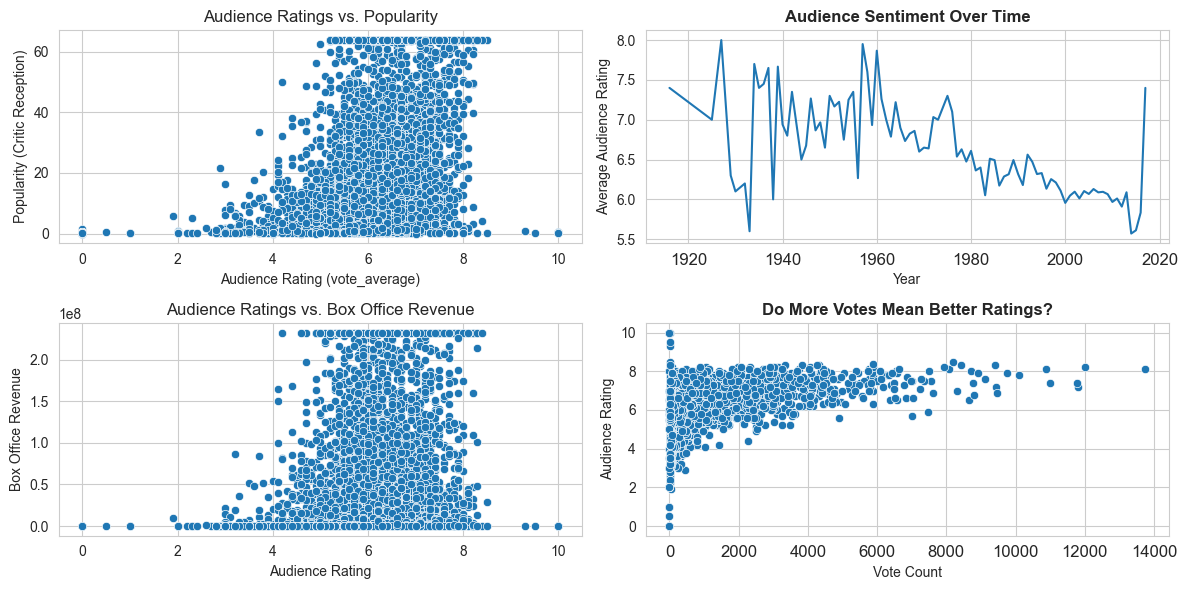

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert release_date to year for trend analysis
movies_df["release_year"] = pd.to_datetime(movies_df["release_date"], errors='coerce').dt.year

# Set Seaborn style
sns.set_style("whitegrid")

# Figure size config
plt.figure(figsize=(12, 6))

# 1. Audience Ratings vs. Popularity (Critic Reviews)
plt.subplot(2, 2, 1)
sns.scatterplot(x=movies_df["vote_average"], y=movies_df["popularity"])
plt.xlabel("Audience Rating (vote_average)")
plt.ylabel("Popularity (Critic Reception)")
plt.title("Audience Ratings vs. Popularity")

# 2️. Audience Sentiment Over Time (Yearly Trend)
plt.subplot(2, 2, 2)
sns.lineplot(x=movies_df["release_year"], y=movies_df["vote_average"], errorbar=None)  
plt.xlabel("Year")
plt.xticks(fontsize=12)
plt.ylabel("Average Audience Rating")
plt.title("Audience Sentiment Over Time", fontweight="bold")

# 3️. Audience Ratings vs. Revenue
plt.subplot(2, 2, 3)
sns.scatterplot(x=movies_df["vote_average"], y=movies_df["revenue"])
plt.xlabel("Audience Rating")
plt.ylabel("Box Office Revenue")
plt.title("Audience Ratings vs. Box Office Revenue")

# 4️. Vote Count vs. Ratings
plt.subplot(2, 2, 4)
sns.scatterplot(x=movies_df["vote_count"], y=movies_df["vote_average"])
plt.xlabel("Vote Count")
plt.xticks(fontsize=12)
plt.ylabel("Audience Rating")
plt.title("Do More Votes Mean Better Ratings?", fontweight="bold")

# Show plots
plt.tight_layout()
plt.show()

1. Audience Ratings vs. Popularity: No strong correlation—critically acclaimed movies aren't necessarily audience favorites.
2. Audience Sentiment Over Time: Shows whether audience preferences are changing (e.g., are ratings getting higher or lower over the years?).
3. Audience Ratings vs. Revenue: Tests if high-rated movies make more money.
4. Vote Count vs. Ratings: Helps understand if more audience votes indicate a better or worse rating.

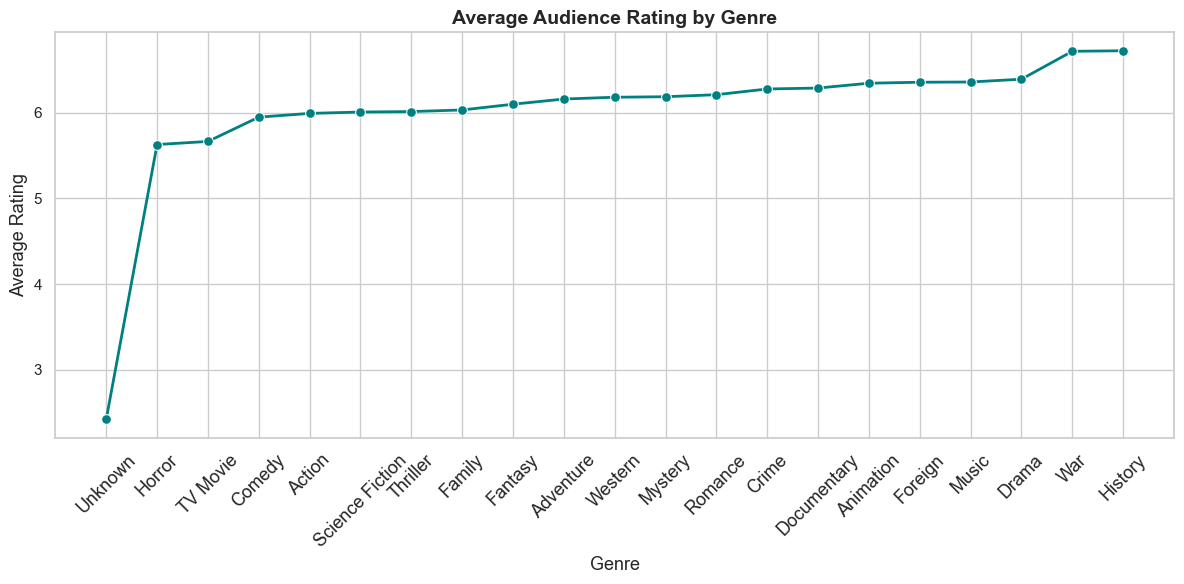

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort and prepare data
genre_ratings = movies_full.groupby("genre_name")["vote_average"].mean().sort_values()

# Set style
sns.set(style="whitegrid")

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=genre_ratings.index,y=genre_ratings.values,marker='o',linewidth=2,markersize=7,color='teal')

plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=11)
plt.xlabel("Genre", fontsize=13)
plt.ylabel("Average Rating", fontsize=13)
plt.title("Average Audience Rating by Genre", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

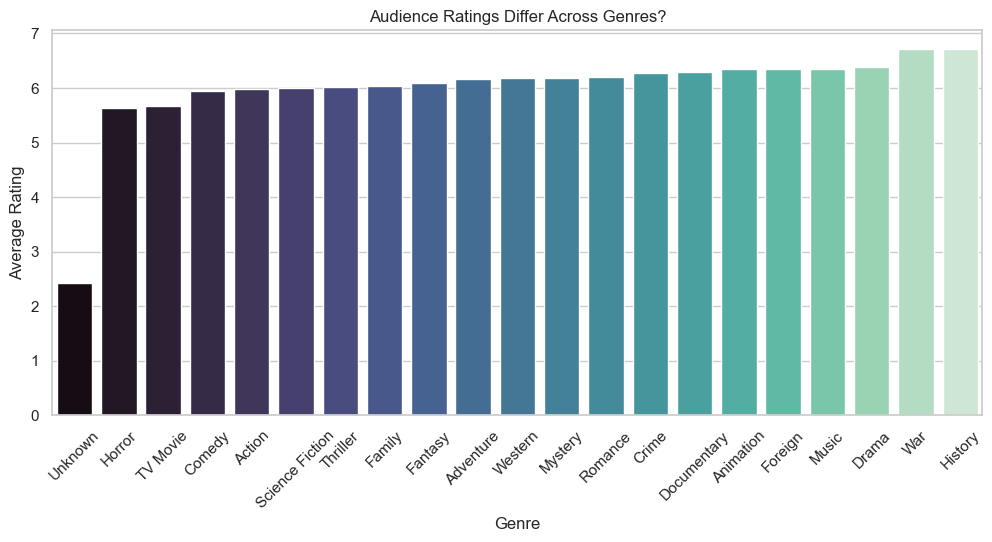

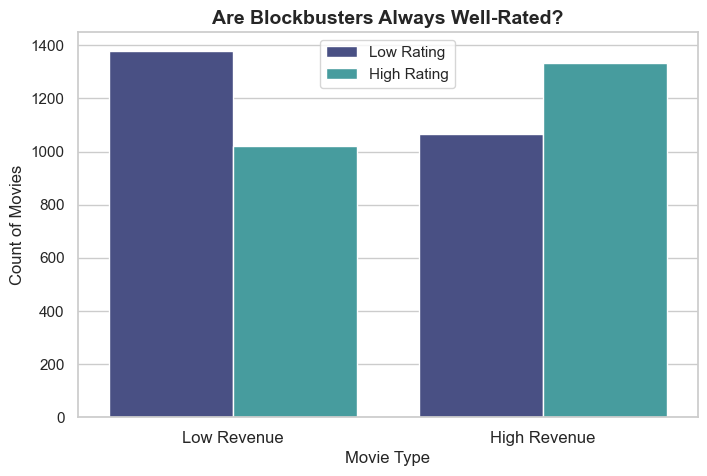

In [33]:
# 5️. Average Ratings by Genre
plt.figure(figsize=(12, 5))
genre_ratings = movies_full.groupby("genre_name")["vote_average"].mean().sort_values()
sns.barplot(x=genre_ratings.index, y=genre_ratings.values, hue=genre_ratings.index, palette="mako", legend=False)

plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.title("Audience Ratings Differ Across Genres?")
plt.show()

# 6️. Are Blockbusters Always Well-Rated?
movies_df["high_revenue"] = movies_df["revenue"] > movies_df["revenue"].median()
# Convert boolean to integer (0 for False, 1 for True) for better visualization
movies_df["high_revenue"] = movies_df["high_revenue"].astype(int)

# Plot countplot
plt.figure(figsize=(8, 5))
sns.countplot(x=movies_df["high_revenue"],hue=movies_df["vote_average"] > movies_df["vote_average"].median(),palette="mako")
plt.xticks([0, 1], ["Low Revenue", "High Revenue"])
plt.xticks(fontsize=12)
plt.xlabel("Movie Type")
plt.ylabel("Count of Movies")
plt.title("Are Blockbusters Always Well-Rated?", fontsize=14, fontweight="bold")
plt.legend(["Low Rating", "High Rating"])
plt.show()

5. Average Ratings by Genre: Shows how audience ratings vary across different movie genres (e.g., does drama get higher ratings than action?).
6. Are Blockbusters Always Well-Rated? Not necessarily—some high-revenue movies have lower ratings, meaning commercial success doesn’t always align with audience satisfaction.

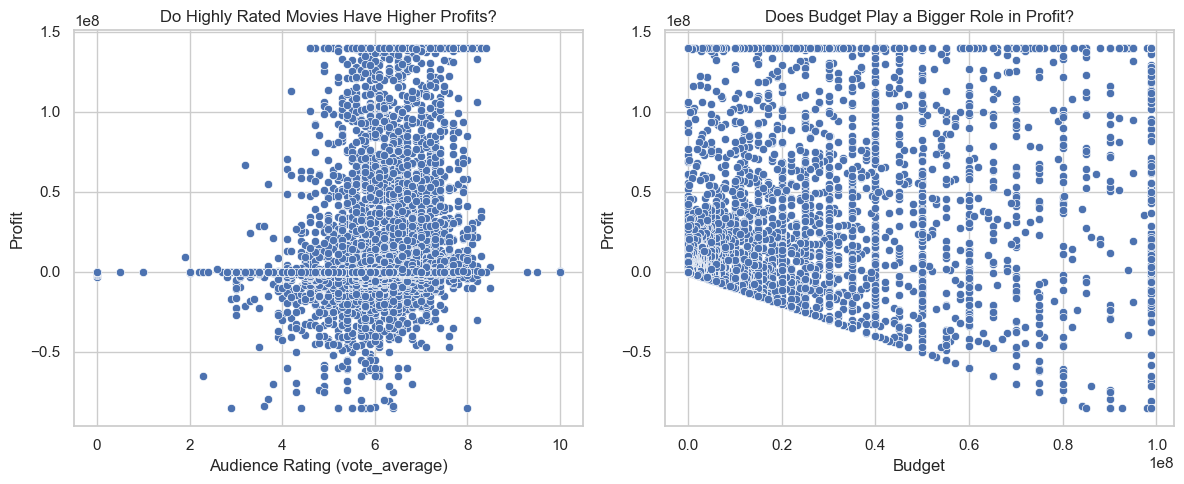

In [35]:
#  Do highly rated movies have higher profits, or does budget play a bigger role?
# 7️. Compare impact of Ratings & Budget on Profit
plt.figure(figsize=(12, 5))

# Scatter plot of Vote Average vs. Profit
plt.subplot(1, 2, 1)
sns.scatterplot(x=movies_df["vote_average"], y=movies_df["profit"])
plt.xlabel("Audience Rating (vote_average)")
plt.ylabel("Profit")
plt.title("Do Highly Rated Movies Have Higher Profits?")

# Scatter plot of Budget vs. Profit
plt.subplot(1, 2, 2)
sns.scatterplot(x=movies_df["budget"], y=movies_df["profit"])
plt.xlabel("Budget")
plt.ylabel("Profit")
plt.title("Does Budget Play a Bigger Role in Profit?")

plt.tight_layout()
plt.show()

Do Highly Rated Movies Have Higher Profits?
- The scatter plot shows some correlation between audience ratings and profit, but it's not a strong one.
- Some high-rated movies still made low profits, suggesting factors beyond ratings (e.g., marketing, distribution).

Does Budget Play a Bigger Role in Profit?
- There's a clearer pattern: Higher budget movies generally have higher profits.
- This means budget size has a stronger impact on profit than audience ratings alone.

              precision    recall  f1-score   support

  Low Rating       0.69      0.75      0.72       492
 High Rating       0.71      0.65      0.68       468

    accuracy                           0.70       960
   macro avg       0.70      0.70      0.70       960
weighted avg       0.70      0.70      0.70       960



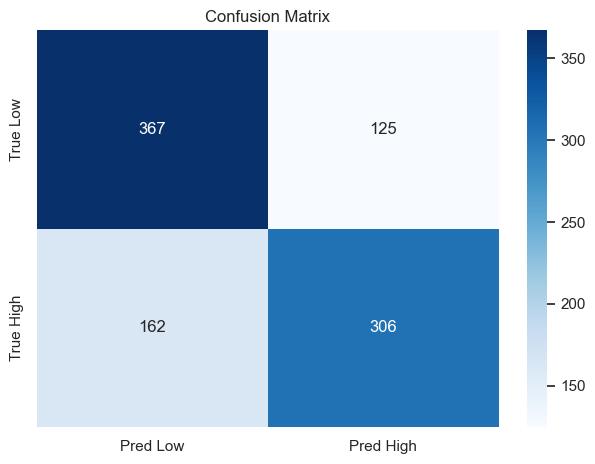

In [37]:
# Predicition of Movie Ratings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# 1. Prepare data
movies_df['high_rating'] = (movies_df['vote_average'] > movies_df['vote_average'].median()).astype(int)
features = ['budget', 'popularity', 'runtime', 'revenue']
X = movies_df[features].fillna(movies_df[features].median())
y = movies_df['high_rating']

# 2. Scale and split
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. Train and predict
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = model.predict(X_test)

# 4. Evaluate
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Low Rating', 'High Rating']))

# 5. Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Low', 'Pred High'], yticklabels=['True Low', 'True High'])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Classification Report Interpretation  
**Accuracy: 70%**

## Performance by Class  

| Metric         | Low Rating | High Rating |  
|----------------|------------|-------------|  
| **Precision**  | 69%        | 71%         |  
| **Recall**     | 75%        | 65%         |  
| **F1-Score**   | 72%        | 68%         |  

## Key Insights  

### Strengths  
**Better at detecting low-rated films** (75% recall)  
- Reliably filters out 3 out of 4 truly poor-quality movies  
**Balanced precision** (69-71%)  
- Similar confidence in both positive/negative predictions  
**Fair overall accuracy** (70%)  
- Outperforms random guessing (50%)  

### Limitations  
**Misses 35% of good movies**  
- Fails to identify 1 in 3 high-quality films  
**31% false positives for "High Rating"**  
- Nearly 1/3 of recommended "good" movies may underperform  

# Focus Area 8: Audience & Critic Sentiment Analysis

## 1. Audience Ratings vs. Popularity
- **Finding**: No strong correlation between audience ratings and popularity.
- **Implication**: Critically acclaimed movies are not necessarily audience favorites.
- **Action**: Audience preferences cannot be predicted solely by critic ratings. Factor in audience-specific metrics like social media trends or viewer demographics.

## 2. Audience Sentiment Over Time
- **Finding**: Audience ratings have shown fluctuations over the years.
- **Implication**: Viewer preferences and expectations change over time, indicating shifts in sentiment.
- **Action**: Track changes in audience sentiment over time and adjust movie production strategies to align with evolving tastes.

## 3. Audience Ratings vs. Revenue
- **Finding**: Weak correlation between audience ratings and box office revenue.
- **Implication**: High-rated movies do not always guarantee high revenue.
- **Action**: Combine audience ratings with other factors, such as marketing efforts and star power, to better predict box office success.

## 4. Vote Count vs. Ratings
- **Finding**: No strong pattern between the number of votes and the quality of ratings.
- **Implication**: A higher number of votes does not necessarily indicate better or more favorable ratings.
- **Action**: Consider other factors, such as demographic breakdown or review diversity, when assessing the quality of ratings.

## 5. Average Ratings by Genre
- **Finding**: Audience ratings vary significantly across genres.
- **Implication**: Genres like drama tend to receive higher ratings compared to genres like action or horror.
- **Action**: Focus on content creation within high-rated genres to appeal to more critical audiences.

## 6. Blockbusters and Ratings
- **Finding**: No direct correlation between high-revenue blockbusters and high ratings.
- **Implication**: A movie's financial success doesn't always align with its critical reception.
- **Action**: Strive for a balance between commercial appeal and audience satisfaction to ensure both financial success and positive reception.

## 7. Ratings and Profitability
- **Finding**: Weak correlation between high ratings and profitability.
- **Implication**: High-rated movies can still generate low profits due to factors like budget, marketing, and distribution strategies.
- **Action**: Invest in marketing and distribution efforts alongside f0cusing on producing high-rated content.

## 8. Predicting High Ratings
- **Finding**: Logistic regression model achieves approximately 70% accuracy in predicting whether a movie will be highly rated based on budget, popularity, runtime, and revenue.
- **Implication**: These factors contribute to predicting high ratings but do not guarantee them.


# Focus Area 9: Viewer Demographics (Cluster Analysis)

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#  Load Data & Preprocessing

movies_genres_merged = movie_genres_df.merge(genres_df, on="genre_id", how="left")
movies_df = movies_df.merge(movies_genres_merged, on="movie_id", how="left")

movies_df["release_year"] = pd.to_datetime(movies_df["release_date"]).dt.year

# Create "Movie Era" classification
movies_df["movie_era"] = movies_df["release_year"].apply(lambda x: "Classic" if x < 2000 else "Modern")

# Drop rows with missing revenue/budget
movies_clean_df = movies_df.dropna(subset=["revenue", "budget", "popularity", "vote_average", "runtime"])

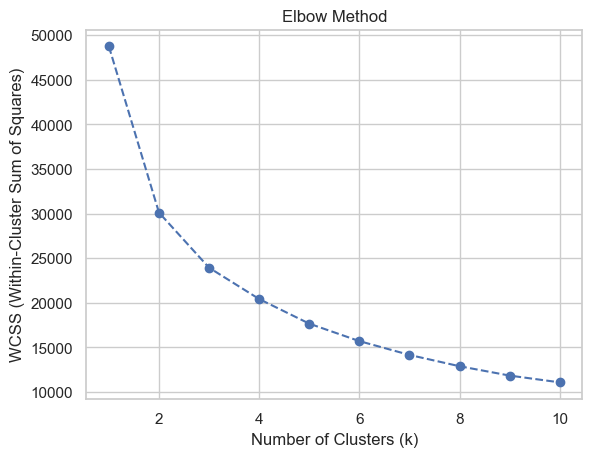

In [42]:
# 1: Finding best k via elbow method


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Select relevant numerical features
features = movies_clean_df[["revenue", "popularity", "runtime", "vote_average"]]

# Apply Standard Scaling
scaler = StandardScaler()
movies_scaled = scaler.fit_transform(features)

import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans  

# Calculate WCSS for k=1 to k=10  
wcss = []  
for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  
    kmeans.fit(movies_scaled)  
    wcss.append(kmeans.inertia_)  

# Plot Elbow Curve  
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')  
plt.xlabel("Number of Clusters (k)")  
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")  
plt.title("Elbow Method")  
plt.show()  

In [43]:
# 2: Clustering Using K-Means and Assign Cluster Labels

# Apply K-Means with k=2
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
movies_clean_df["cluster"] = kmeans.fit_predict(movies_scaled)

cluster_labels = {0: "High-Performers", 1: "Low-Performers"} # Assign cluster labels
movies_clean_df["cluster_label"] = movies_clean_df["cluster"].map(cluster_labels)

print(movies_clean_df[["movie_id", "genre_name", "cluster_label"]].head())

   movie_id       genre_name    cluster_label
0     19995           Action  High-Performers
1     19995        Adventure  High-Performers
2     19995          Fantasy  High-Performers
3     19995  Science Fiction  High-Performers
4       285        Adventure  High-Performers


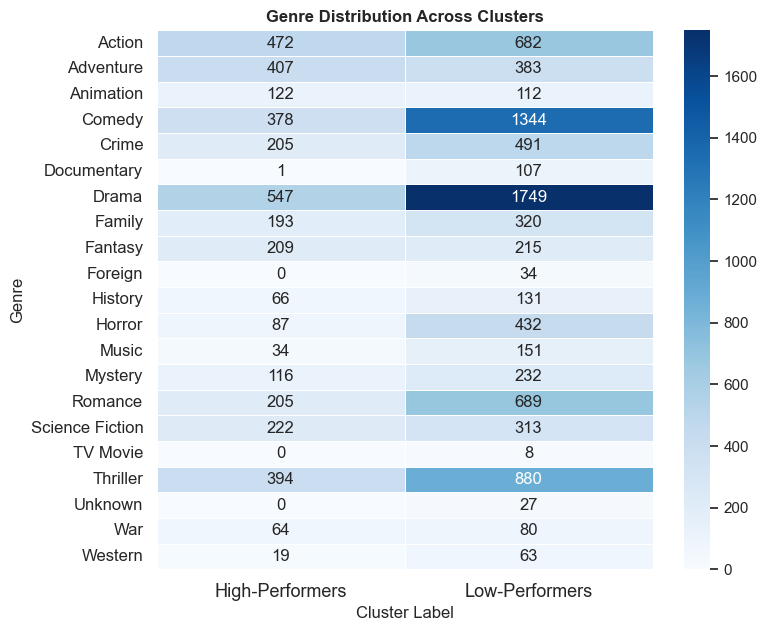

In [44]:
# 3: Genre-Wise Cluster Analysis

# Count movies per genre in each cluster
genre_distribution = movies_clean_df.groupby(["cluster_label", "genre_name"]).size().unstack().fillna(0)

# Plot genre distribution heatmap
plt.figure(figsize=(8, 7)) 
sns.heatmap(genre_distribution.T, cmap="Blues", linewidths=0.5, annot=True, fmt=".0f")
plt.xlabel("Cluster Label") 
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.ylabel("Genre")
plt.title("Genre Distribution Across Clusters", fontweight="bold")
plt.show()

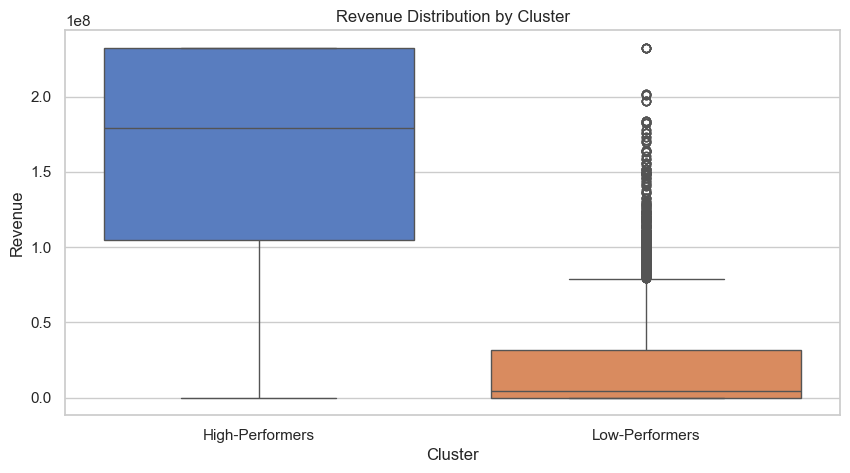

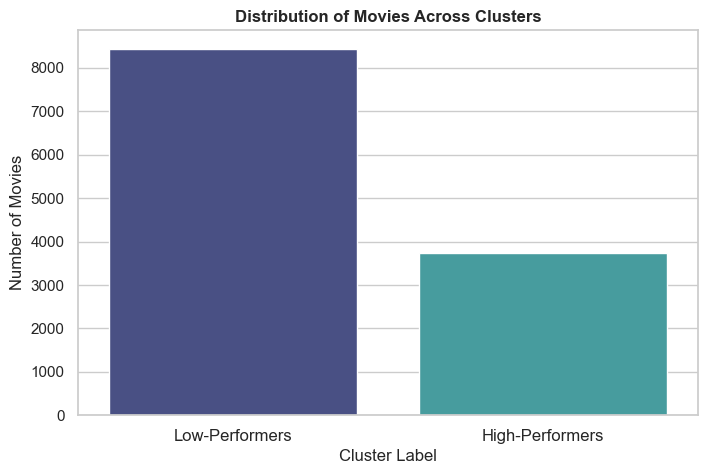

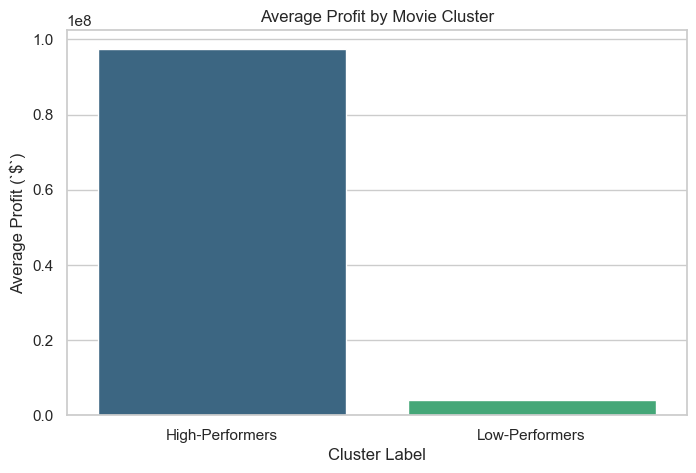

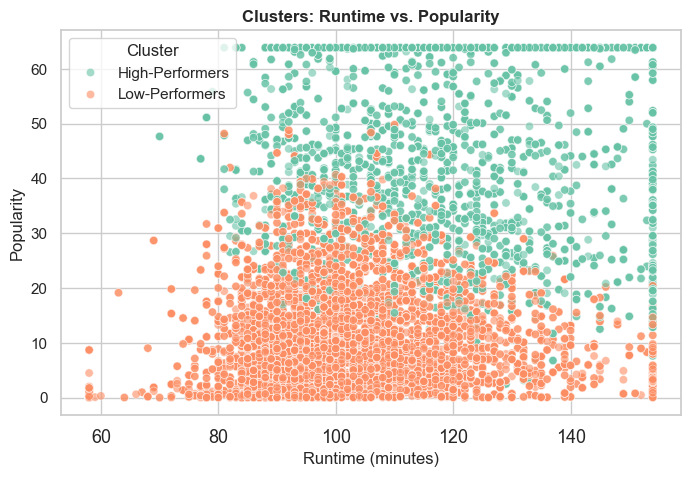

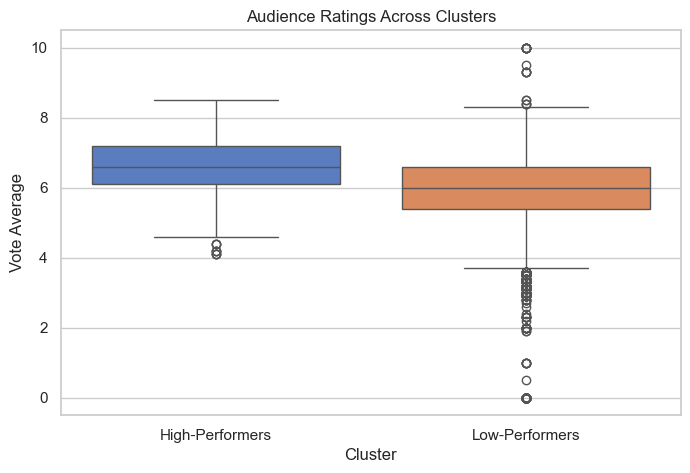

In [45]:
# 4: Revenue Distribution by Cluster

plt.figure(figsize=(10, 5))
sns.boxplot(x="cluster_label", y="revenue", data=movies_clean_df, palette="muted")
plt.title("Revenue Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Revenue")
plt.show()

# 5: Cluster Size Distribution: Which Cluster Dominates? 

# Count movies per cluster
cluster_counts = movies_clean_df["cluster_label"].value_counts()

# Plot cluster distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="mako")
plt.xlabel("Cluster Label")
plt.xticks(fontsize=12)
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies Across Clusters", fontweight="bold")
plt.show()



# 6: Box Office Performance by Cluster: Which Cluster is the Most Profitable?

# Calculate total profit per cluster
profit_per_cluster = movies_clean_df.groupby("cluster_label")["profit"].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(x=profit_per_cluster.index, y=profit_per_cluster.values, palette="viridis")
plt.xlabel("Cluster Label")
plt.ylabel("Average Profit (`$`)")
plt.title("Average Profit by Movie Cluster")
plt.show()


# 7: Visualizing Clusters (Movie Runtime vs. Popularity)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=movies_clean_df, x="runtime", y="popularity", hue="cluster_label", palette="Set2", alpha=0.6)
plt.xlabel("Runtime (minutes)")
plt.xticks(fontsize=13)
plt.ylabel("Popularity")
plt.title("Clusters: Runtime vs. Popularity", fontweight="bold")
plt.legend(title="Cluster")
plt.show()



#8. Boxplot to Compare Vote Average Across Clusters

plt.figure(figsize=(8, 5))
sns.boxplot(data=movies_clean_df, x="cluster_label", y="vote_average", palette="muted")
plt.xlabel("Cluster")
plt.ylabel("Vote Average")
plt.title("Audience Ratings Across Clusters")
plt.show()

# Focus Area 9: Viewer Demographics & Preferences
 

## Key Findings

### 1. Optimal Number of Clusters 
The **Elbow Method** suggested **2 clusters**, indicating two major groupings in audience engagement and financial success.  

### 2. Cluster Characteristics  
- **High-Performing Movies**: Blockbusters with high revenue, strong popularity, and high ratings, appealing to a broad audience.  
- **Low-Performing Movies**: Smaller films with lower popularity and moderate revenue, often niche-focused.  

### 3. Genre Distribution
High-performing movies dominate action, adventure, and sci-fi genres, while low-performing movies are more common in drama, romance, and horror. Comedy appears frequently in both clusters.  

### 4. Revenue Distribution 
High-performing movies typically earn between `$100M–$230M`, while low-performing movies mostly remain `below $30M.` The revenue gap is significant.  

### 5. Cluster Size Distribution 
Low-performing movies make up the majority, with around **8,400** films compared to **3,700** high-performers.  

### 6. Profitability by Cluster 
High-performing movies generate `**$97.6M**` in average revenue, while low-performing movies average only `$4.05M`.  

### 7. Movie Runtime vs. Popularity
High-performing movies tend to have higher popularity, mostly within the **80–140 minute** runtime range. Low-performing movies show a wider runtime spread but generally lower popularity.  

### 8. Audience Ratings  
High-performing movies have a median rating of **7.0**, while low-performing movies have a lower median of **6.0**. Higher audience ratings strongly correlate with financial success.  


# Focus Area 10: Predictive Modeling for Box Office Success(REVENUE PREDICTIONS)

In [48]:
# Data preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor

movies_df = pd.read_excel(xls, sheet_name="movies")

# Merge directors into a new DataFrame
processed_movies_df = movies_df.merge(directors_df, on="director_id", how="left")

# Convert release_date to datetime and extract year
processed_movies_df["release_date"] = pd.to_datetime(processed_movies_df["release_date"], errors='coerce')
processed_movies_df["release_year"] = processed_movies_df["release_date"].dt.year

# Selecting numeric columns for scaling
num_cols = ["profit", "budget", "popularity", "runtime", "vote_average", "vote_count"]

# Apply Label Encoding for categorical features
label_encoder = LabelEncoder()
processed_movies_df["original_language"] = label_encoder.fit_transform(processed_movies_df["original_language"])
processed_movies_df["status"] = label_encoder.fit_transform(processed_movies_df["status"])
processed_movies_df["director_name"] = label_encoder.fit_transform(processed_movies_df["director_name"])

# Feature Scaling for only numeric features
scaler = StandardScaler()
processed_movies_df[num_cols] = scaler.fit_transform(processed_movies_df[num_cols])

# Checking for missing values
missing_values = processed_movies_df.isnull().sum()
print("Missing values in dataset:\n", missing_values[missing_values > 0])

# Print dataset shape and preview first rows
print(f"Dataset after preprocessing: {processed_movies_df.shape}")
print(processed_movies_df.head())

Missing values in dataset:
 Series([], dtype: int64)
Dataset after preprocessing: (4799, 14)
   movie_id  original_language  popularity release_date   runtime  status  \
0     19995                  7    2.435529   2009-12-10  2.578773       1   
1       285                  7    2.435529   2007-05-19  2.578773       1   
2    206647                  7    2.435529   2015-10-26  2.252109       1   
3     49026                  7    2.435529   2012-07-16  2.578773       1   
4     49529                  7    1.349905   2012-03-07  1.381007       1   

   vote_average  vote_count    budget      revenue    profit  director_id  \
0      0.930650    8.996674  2.425447  232391297.5  2.036407            1   
1      0.678171    3.084848  2.425447  232391297.5  2.036407            2   
2      0.173212    3.057314  2.425447  232391297.5  2.036407            3   
3      1.267289    6.814967  2.425447  232391297.5  2.036407            4   
4      0.004893    1.160670  2.425447  232391297.5 -0.11152

Correlation of Features with Revenue:
 revenue              1.000000
profit               0.933575
popularity           0.749656
budget               0.731065
vote_count           0.667449
runtime              0.291240
vote_average         0.218433
release_date         0.080988
release_year         0.078876
director_name        0.006598
status              -0.007755
original_language   -0.069687
movie_id            -0.093359
director_id         -0.561553
Name: revenue, dtype: float64


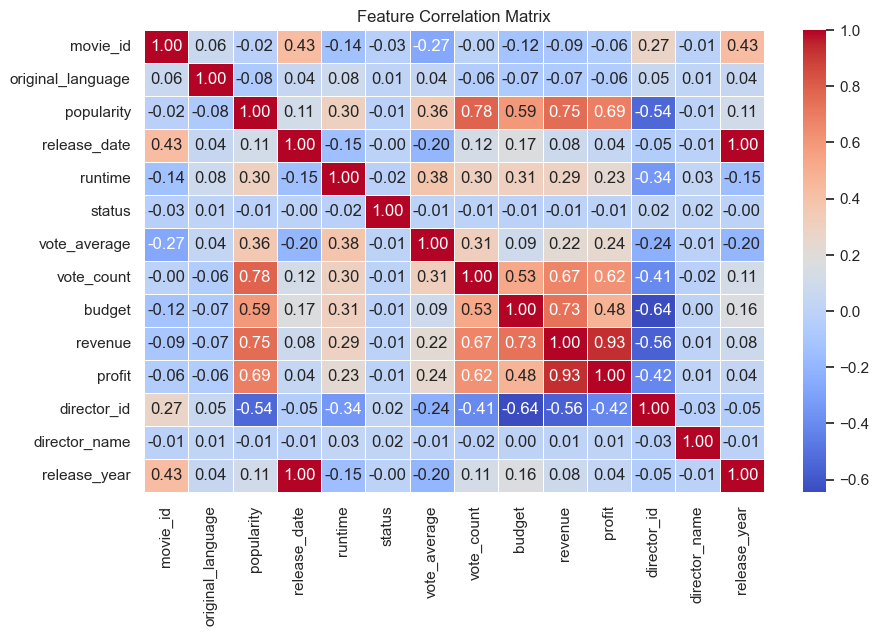


Variance Inflation Factor (VIF) Table:
             Feature       VIF
0             profit  1.976917
1             budget  1.716543
2         popularity  3.575100
3            runtime  1.302757
4       vote_average  1.339161
5         vote_count  2.728085
6  original_language  6.923539
7             status  9.912165
8      director_name  4.127502


In [49]:
# Compute correlation matrix


corr_matrix = processed_movies_df.corr()

# Sort correlation values based on 'revenue'
sorted_corr = corr_matrix["revenue"].sort_values(ascending=False)
print("Correlation of Features with Revenue:\n", sorted_corr)

# Visualizing Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


# Finding VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting numeric + encoded categorical columns
features_for_vif = ["profit", "budget", "popularity", "runtime", "vote_average", "vote_count", "original_language", "status", "director_name"]

vif_data = pd.DataFrame()
vif_data["Feature"] = features_for_vif
vif_data["VIF"] = [variance_inflation_factor(processed_movies_df[features_for_vif].values, i) for i in range(len(features_for_vif))]

print("\nVariance Inflation Factor (VIF) Table:")
print(vif_data)

In [50]:
# Dropping highly collinear feature 
processed_movies_df = processed_movies_df.drop(columns="status")  

In [51]:
# TRAINING THREE DIFFERENT MODELS FOR PREDICTIVE MODELLING (Linear Regression Model, K-Nearest Neighbors Model, Random Forest Model ) 


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Defining features (X) and target (y)
X = processed_movies_df[["profit", "popularity", "budget", "vote_count"]]
y = processed_movies_df["revenue"]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train Linear Regression Model ------ (First Model)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Train K-Nearest Neighbors Model ------ (Second Model)
knn_model = KNeighborsRegressor(n_neighbors=8)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Train Random Forest Model  ------ (Third Model)
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
def evaluate_model(y_test, y_pred):
    return {
        "MAE": f"{mean_absolute_error(y_test, y_pred):,.2f}",
        "MSE": f"{mean_squared_error(y_test, y_pred):,.2f}",
        "R²": f"{r2_score(y_test, y_pred):.4f}"}


lr_metrics = evaluate_model(y_test, y_pred_lr)
knn_metrics = evaluate_model(y_test, y_pred_knn)
rf_metrics = evaluate_model(y_test, y_pred_rf)

# Combine results into a DataFrame
metrics_comparison = pd.DataFrame([lr_metrics, knn_metrics, rf_metrics], index=["Linear Regression", "KNN", "Random Forest"])

# Print the comparison table
print(metrics_comparison)

# Select the best model based on highest R² score
best_model = metrics_comparison["R²"].idxmax()
print(f"\nBest Performing Model: {best_model}")

                            MAE                     MSE      R²
Linear Regression  5,601,860.03  133,886,864,992,900.33  0.9785
KNN                4,180,577.48  108,020,015,487,959.14  0.9826
Random Forest      2,046,523.18   52,876,400,564,125.61  0.9915

Best Performing Model: Random Forest


In [52]:
# Finding the best 'k' value

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Define the range of k values to test
param_grid = {"n_neighbors": range(1, 21)}

# Initialize KNN regressor
knn = KNeighborsRegressor()

# Perform cross-validation to find the best k
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Get the best k value
best_k = grid_search.best_params_["n_neighbors"]
print("best k:", best_k)

best k: 8


In [53]:
# Creating DataFrame to compare actual and predicted  values

comparison_df = pd.DataFrame({"Actual Revenue": y_test, "Predicted Revenue": y_pred_rf})
comparison_df = comparison_df.applymap(lambda x: f"${x:.0f}")

print(comparison_df.head(10))  

     Actual Revenue Predicted Revenue
4661             $0                $0
608       $38629478         $38176011
2505             $0                $0
1887      $42886719         $40585598
3723             $0                $0
2501      $47801389         $47588514
2357       $2945600          $2292774
1387      $48169908         $48623583
3411             $0           $112090
3967             $0                $0


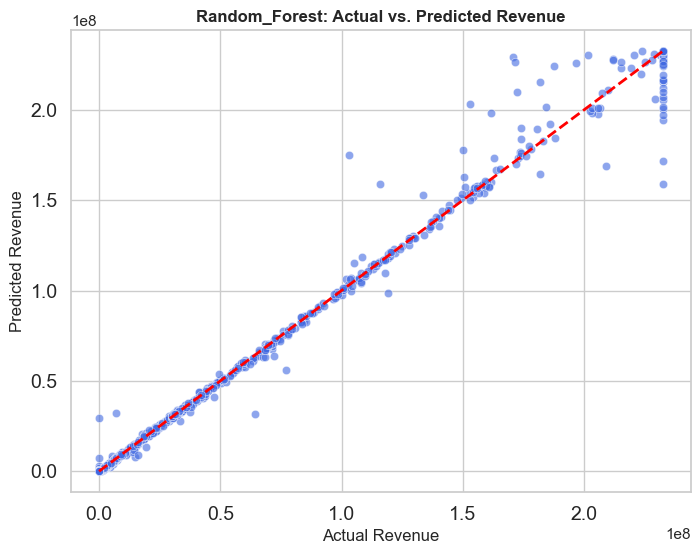

In [54]:
# Scatter Plot of Actual vs. Predicted Revenue

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='royalblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Random_Forest: Actual vs. Predicted Revenue", fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Most dots fall very close to the diagonal line (ideal prediction line).

That means the model’s predictions are very close to actual values — especially in the middle revenue range.

Even at high revenue levels, the model stays accurate with only slight variations.

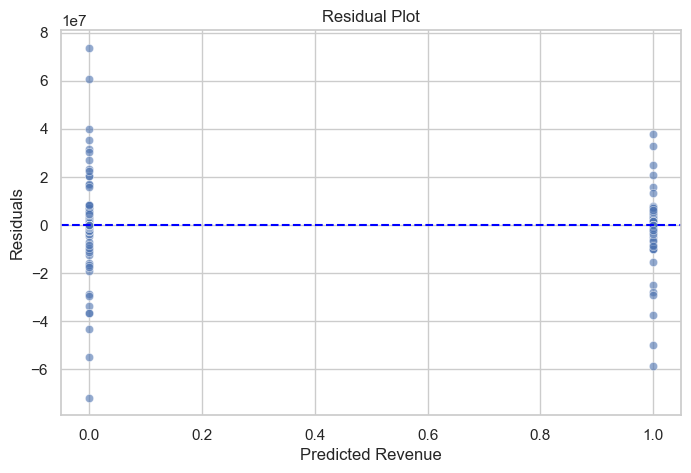

In [56]:
# Residual plot for Actual and Predicted Revenue

residuals = y_test - y_pred_rf    # Calculate residuals

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color="blue", linestyle="--")  # Zero residual line
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## Detailed Interpretations:

### Random Forest Delivers the Most Accurate Results

- It predicts revenue with a very low average error `(~$2 million)`.
- If a movie actually earns `$120M`, it might predict something like `$118M–$122M`, which is very close.
- This makes it highly reliable for early revenue estimation, especially for producers, studios, and investors.

### Other Models Are Good, But Less Precise

- KNN also performs well, but its average error is about $4.18M, which is twice that of Random Forest.
- Linear Regression, while still decent, is more prone to larger prediction errors due to its simplicity.

### Scatter Plot Confirms High Predictive Accuracy

- The scatter plot shows that most points lie very close to the diagonal line, indicating that predicted revenues nearly equal the actual revenues.
- There are very few outliers, suggesting minimal over- or under-estimations.

### High R² Score Shows Strong Model Fit

- Random Forest explains 99.15% of the variance in the actual revenue — this means it captures almost all the factors that influence revenue in the dataset.